In [1]:
import pylab as plt
import numpy as np
import pandas as pd
import proposal as pp  #installed with pip
import scipy
from scipy import interpolate
from scipy.interpolate import InterpolatedUnivariateSpline
# matplotlib used plotting. Not required to run the code.
import matplotlib.pyplot as plt
import re
import sys
import glob
from MCEq.core import config, MCEqRun
import crflux.models as crf
# matplotlib used plotting. Not required to run the code.
import matplotlib.pyplot as plt
import random
try:
    import cPickle as pickle
except ImportError:
    import pickle

In [2]:
def get_color(n, colormax, cmap="PiYG"):
    
    this_cmap = plt.get_cmap(cmap)
    return this_cmap(n/colormax)


In [3]:
def GetMuonInfo(startMuon):
    depthMuon   = np.round(depth(*startMuon)[0],2)
    distMuon    = np.round(rocklength(*startMuon)[0],2)
    thMuon      = np.round(np.rad2deg(np.arctan2((startMuon[0]**2+startMuon[1]**2)**0.5,depthMuon)),2)
    phiMuon     = np.round(np.rad2deg(np.arctan2(startMuon[1],startMuon[0])),2)
    return thMuon,phiMuon,depthMuon,distMuon

In [4]:
####loading mountain profile####
pdmtn=pd.read_hdf('/Users/rogerslc/Documents/MuFluxPred/MountainProfile.h5')


Ymax=int(np.round(pdmtn['Y'].max(),0))
Xmax=int(np.round(pdmtn['X'].max(),0))
Ymin=int(np.round(pdmtn['Y'].min(),0))
Xmin=int(np.round(pdmtn['X'].min(),0))

Del=100

vals=[]
phi=[]
X1= range(Xmin,Xmax, Del)
Y1= range(Ymin,Ymax, Del)
for ys in Y1:
    for xs in X1:   
        pts=pdmtn[(pdmtn.X>=xs) &(pdmtn.X<=xs+Del)&(pdmtn.Y>=ys) &(pdmtn.Y<=ys+Del)].Z.unique()
        ptsz=np.mean(pts)       
        vals.append(ptsz)
        

        
vals = np.array(vals)
where_are_NaNs = np.isnan(vals)
vals[where_are_NaNs] = 200
zz=vals.reshape(len(Y1), len(X1))
[xx,yy]=np.meshgrid(np.arange(Xmin,Xmax,Del),np.arange(Ymin,Ymax,Del))

#Find the thetas and phis and distance through rock for each grid square
phioffset=0                      # Orientation of detector relative to map - you need to figure this out.
rho=(xx**2+yy**2)**0.5           # cylindrical rho coordinate
theta=np.arctan(rho/zz)          # spherical theta coordinate (0 = downgoing)
phi = np.arctan(yy/xx) + phioffset # spherical phi coordinate
distancetodetector = np.sqrt(zz**2+xx**2+yy**2)

# continuously interpolate rock length and depth functions so we can sample at any X,Y
rocklength=scipy.interpolate.interp2d(xx,yy,distancetodetector)
depth     =scipy.interpolate.interp2d(xx,yy,zz)

pdmtn['theta']=pdmtn.apply(lambda row: GetMuonInfo([row.X,row.Y])[0], axis=1)
pdmtn['phi']=pdmtn.apply(lambda row: GetMuonInfo([row.X,row.Y])[1], axis=1)

/usr/local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/var/folders/jm/hwfgsj_5419b1s2h09k6lflr6k3jsz/T/ipykernel_45838/4081877176.py:33: RuntimeWarning: divide by zero encountered in true_divide
  theta=np.arctan(rho/zz)          # spherical theta coordinate (0 = downgoing)
/usr/local/lib/python3.9/site-packages/scipy/interpolate/_fitpack_impl.py:977: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=25,33 m=693 fp=196.717266 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/usr/local/lib/python3.9/site-packages/scipy/interpolate/_fitpack_impl.py:977: Run

/var/folders/jm/hwfgsj_5419b1s2h09k6lflr6k3jsz/T/ipykernel_45838/1061820620.py:5: RuntimeWarning: divide by zero encountered in true_divide
  thetad=np.arctan(rhod/zz)           # spherical theta coordinate (0 = downgoing)
/var/folders/jm/hwfgsj_5419b1s2h09k6lflr6k3jsz/T/ipykernel_45838/1061820620.py:31: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx,yy,zz,cmap=cmap)


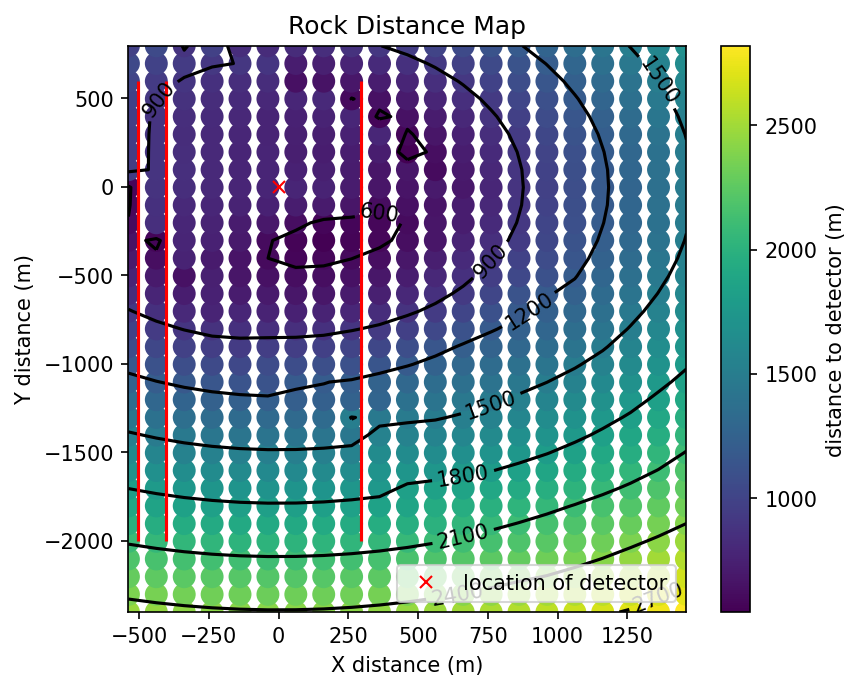

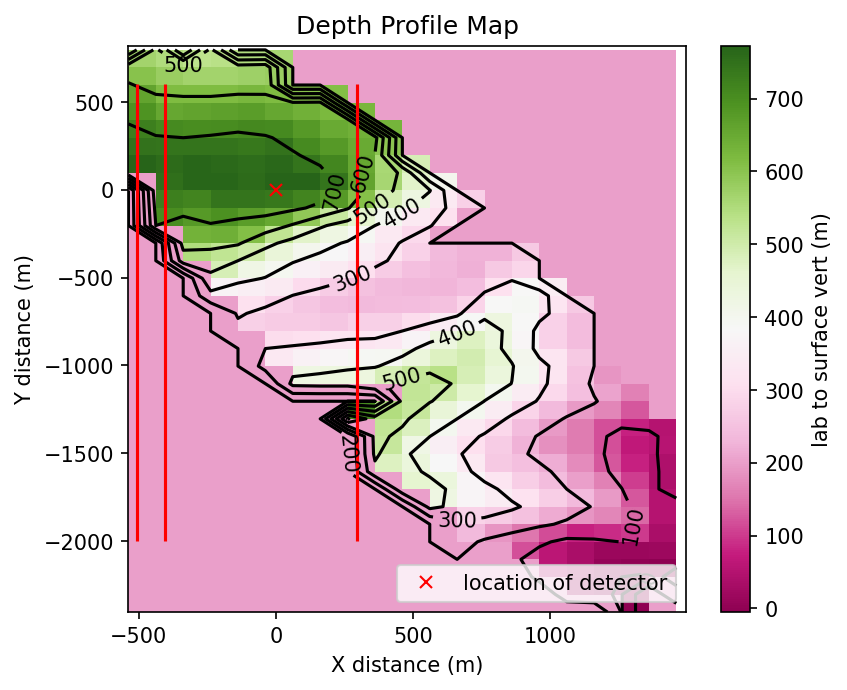

In [5]:
####visualizing mountain profile####
#Find the thetas and phis and distance through rock for each grid square
phioffset=np.pi/3                   # Orientation of detector relative to map - you need to figure this out.
rhod=(xx**2+yy**2)**0.5             # cylindrical rho coordinate
thetad=np.arctan(rhod/zz)           # spherical theta coordinate (0 = downgoing)
phid = np.arctan(yy/xx) + phioffset # spherical phi coordinate
distancetodetectord = np.sqrt(zz**2+xx**2+yy**2)

#Plot the distance from the surface to the lab at each place in XY

plt.figure(figsize=(6,5),dpi=150)
plt.scatter(xx,yy,Del,distancetodetectord)

plt.colorbar(label='distance to detector (m)')
CS=plt.contour(xx,yy,distancetodetectord,colors='black')
plt.clabel(CS, inline=1, fontsize=10,fmt='%1.0f')
plt.vlines(-505,-2000,600,color='red')
plt.vlines(-405,-2000,600,color='red')
plt.vlines(295,-2000,600,color='red')

plt.xlabel("X distance (m)")
plt.ylabel("Y distance (m)")
plt.title("Rock Distance Map")
plt.plot([0],[0],'x',label='location of detector',color='red')
plt.legend(loc='lower right')
cmap = plt.get_cmap('PiYG')


# Plot the height map
plt.figure(figsize=(6,5),dpi=150)
plt.pcolormesh(xx,yy,zz,cmap=cmap)

plt.colorbar(label='lab to surface vert (m)')
CS=plt.contour(xx,yy,zz,colors='black')
plt.clabel(CS, inline=1, fontsize=10,fmt='%1.0f')
plt.vlines(-505,-2000,600,color='red')
plt.vlines(-405,-2000,600,color='red')
plt.vlines(295,-2000,600,color='red')
plt.ylim(Ymin,Ymax)
plt.xlim(Xmin,Xmax)
plt.xlabel("X distance (m)")
plt.ylabel("Y distance (m)")
plt.title("Depth Profile Map")
plt.plot([0],[0],'x',label='location of detector',color='red')
plt.legend(loc='lower right')

In [87]:
CLRS=["gray","firebrick","orchid","deepskyblue","orange","blueviolet","magenta","limegreen","pink","tomato","red","black","yellow","darkgreen"]

energies=[100,250,500,750,1000,1500,2000,3000,4000,5000,6000,7500,8500,10000,11000,12500,15000,20000,25000]
GeV=1000

NumToRun=1000

AreaOfNextNEW=np.pi*(45/2)**2*66 #cm^2 but these dimensions need double checked

In [86]:
np.pi

3.141592653589793

In [7]:
#MCeQ outputs with Phi
r=0

for files in glob.glob('/Users/rogerslc/Documents/MuFluxPred/Phis/Muons*degrees.h5'):
    #print (files,re.search('Muons(.*)degrees', files))
    run=re.search('Muons(.*)degrees', files)
    ths=int(run.group(1))
    if r==0:
        mussimData=pd.read_hdf(files)
        mussimData['theta']=    ths
        r+=1
    else:
        df=pd.read_hdf(files)
        df['theta']=ths
        mussimData=mussimData.append(df, ignore_index=True)
        
mussimData['altitude']=mussimData.altitude*10**-2    
k=mussimData.theta.unique()
k.sort()
l=mussimData.phis.unique()
print(k)
#print(l)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89]


In [8]:
#importing Proposal Outputs
r=0

for files in glob.glob('/Users/rogerslc/PROPOSAL/PROPOSAL/CorrectPercs/ProposalMuons*.h5'):
    #print (files)
    run=re.search('Muons(.*)_', files)
    X=str(run.group(1))
    run=re.search('_(.*).h5', files)
    Y=str(run.group(1))
    if r==0:
        musDatamtn=pd.read_hdf(files)
        musDatamtn['X']=    X
        musDatamtn['Y']=    Y        
        r+=1
    else:
        df=pd.read_hdf(files)
        df['X']=    X
        df['Y']=    Y  
        musDatamtn=musDatamtn.append(df, ignore_index=True)

        
musDatamtn['X'] = musDatamtn['X'].astype(float)        
musDatamtn['Y'] = musDatamtn['Y'].astype(float)          


musDatamtn['Theta']=np.rad2deg(musDatamtn['Theta'])
musDatamtn['Theta']=np.where(musDatamtn['Theta'] <0,musDatamtn['Theta']+180,musDatamtn['Theta'])

musDatamtn=musDatamtn[(musDatamtn.X!=-505)&(musDatamtn.X!=-405)&(musDatamtn.X!=295)]

kX=musDatamtn.X.unique()
kX.sort()
lY=musDatamtn.Y.unique()
lY.sort()
energies=musDatamtn.Energy.unique()
energies.sort()

print(kX,lY,energies)

[-305. -205. -105.   -5.   95.  195.  395.  495.  595.  695.  795.  895.
  995. 1095. 1195. 1295. 1395. 1495.] [-2255. -2155. -2055. -1955. -1855. -1755. -1655. -1555. -1455. -1355.
 -1255. -1155. -1055.  -955.  -855.  -755.  -655.  -555.  -455.  -355.
  -255.  -155.   -55.    45.   145.   245.   345.   445.   545.   645.
   745.] [  100000   250000   500000   750000  1000000  1500000  2000000  3000000
  4000000  5000000  6000000  7500000  8500000 10000000 11000000 12500000
 15000000 20000000 25000000]


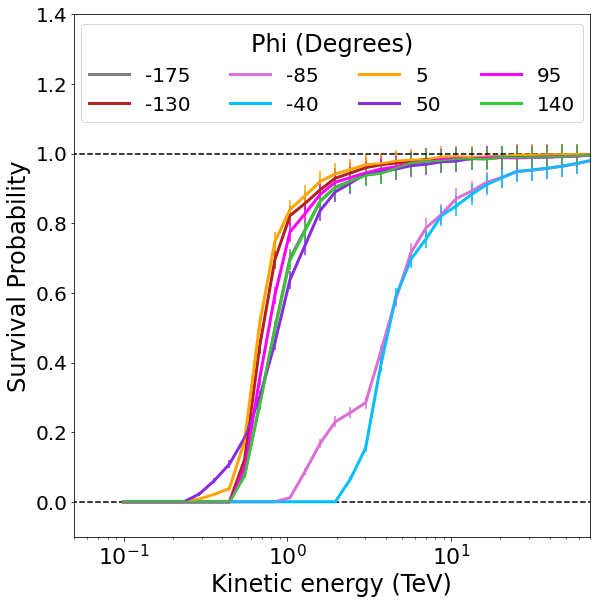

In [9]:

plt.figure(figsize=(8,8))

k=mussimData.theta.unique()
k.sort()
energies=musDatamtn.Energy.unique()

#bring in the intorpolation funcs
with open('/Users/rogerslc/PROPOSAL/PROPOSAL/Proposal_Muons_interpolator_ALL_Phi.pkl', 'rb') as f:
    PercentMuons = pickle.load(f) #use as PercentMuons(energy,theta)

clr=0
nrgs=np.geomspace(np.min(energies*10**-3),4e5,40)
#nrgs=energies*10**-3

    
# The lines below are for plotting with matplotlib
#for theta in k:
for phi in range(-175,180,45):
    flxs=[]     
    err=[]
    for NG in  nrgs:     
        flxs.append(PercentMuons(NG,phi)[0])   
        err.append((PercentMuons(NG,phi)[0]*NumToRun)**.5/1000)
    #plt.plot(nrgs*(GeV/10**6),flxs,linewidth=3,color=CLRS[clr], label=str(theta))
    #plt.errorbar(nrgs*(GeV/10**6),flxs,yerr=err,xerr=None,color=CLRS[clr])
    plt.plot(nrgs*10**-3,flxs,linewidth=3,color=CLRS[clr], label=str(phi))
    plt.errorbar(nrgs*10**-3,flxs,yerr=err,xerr=None,color=CLRS[clr])
    clr+=1
    
plt.hlines(0,10**-2,10**2,color='k',linestyle='--')
plt.hlines(1,10**-2,10**2,color='k',linestyle='--')

#plt.yscale('log')
plt.xscale('log')
plt.xticks(fontsize=22)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.xlim(.05, 7e1)
plt.xlabel('Kinetic energy (TeV)',fontsize=24)
#plt.ylim(-4e-3, 4e-3)
plt.ylim(-.1, 1.4)

plt.ylabel(r'Survival Probability',fontsize=24)
plt.legend(fontsize=20,title='Phi (Degrees)',title_fontsize=24,ncol=4,loc='upper center')
#plt.savefig("/Users/rogerslc/Documents/MuFluxPred/FluxesForSomeDeg.png",dpi=250,bbox_inches='tight')
plt.show()




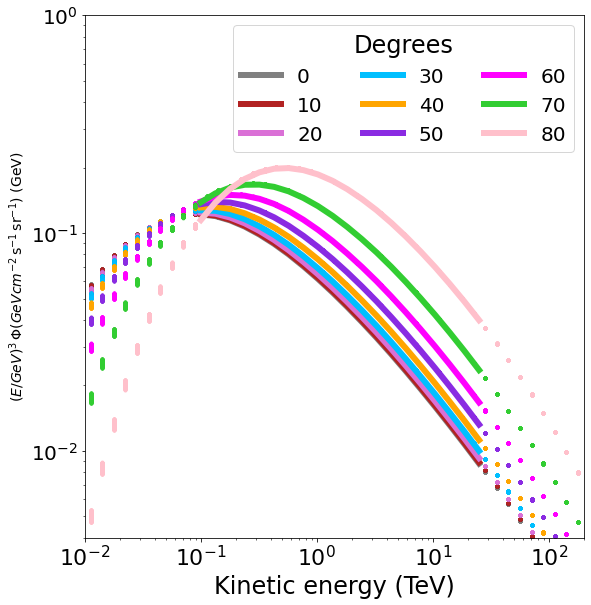

In [10]:
#bring in the intorpolation funcs
with open('/Users/rogerslc/PROPOSAL/PROPOSAL/Proposal_Muons_interpolator_ALL_Phi.pkl', 'rb') as f:
    PercentMuons = pickle.load(f) #use as PercentMuons(energy,theta)


plt.figure(figsize=(8,8))
# Obtain the result
# Multiply fluxes be E**mag to resolve the features of the steep spectrum

k=mussimData.theta.unique()
k.sort()

energies=[100,250,500,750,1000,1500,2000,3000,4000,5000,6000,7500,8500,10000,11000,12500,15000,20000,25000]
clr=0
nrgs=np.geomspace(np.min(energies)*10**-3,np.max(energies)*10**-3,20)
    
# The lines below are for plotting with matplotlib
#for theta in k:
for theta in range(0,90,10):
    #MCeq data
    df=mussimData[(mussimData.theta==theta)&(mussimData.MuFLux>10**-9)]  
    x=df.Energies
    y=df.MuFLux
    
    
    #bring in the intorpolation funcs
    flxs=[]
    with open('/Users/rogerslc/Documents/MuFluxPred/MCeQ_Muons_interpolator'+str(theta)+'.pkl', 'rb') as f:
        FluxMuons = pickle.load(f)
    
    for NG in nrgs:
        flxs.append(FluxMuons(NG/(GeV/10**6),650)[0][0])

    plt.scatter(x*GeV/10**6, y, label='_nolegend_',alpha=.3,s=8,color=CLRS[clr])        
    plt.plot(nrgs,flxs,linewidth=6,color=CLRS[clr], label=str(theta))
    clr+=1
    
plt.yscale('log')
plt.xscale('log')
plt.xticks(fontsize=22)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.xlim(.01, 2e2)
plt.xlabel('Kinetic energy (TeV)',fontsize=24)
#plt.ylim(4e-9, 1.)
plt.ylim(4e-3, 1.)

plt.ylabel(r'$(E/ {GeV})^3\,\Phi (GeV cm^{-2}\,$s$^{-1}\,$sr$^{-1}$) (GeV)',fontsize=14)
plt.legend(fontsize=20,title='Degrees',title_fontsize=24,ncol=3,loc='upper right')
#plt.savefig("/Users/rogerslc/Documents/MuFluxPred/FluxesForSomeDeg.png",dpi=250,bbox_inches='tight')
plt.show()


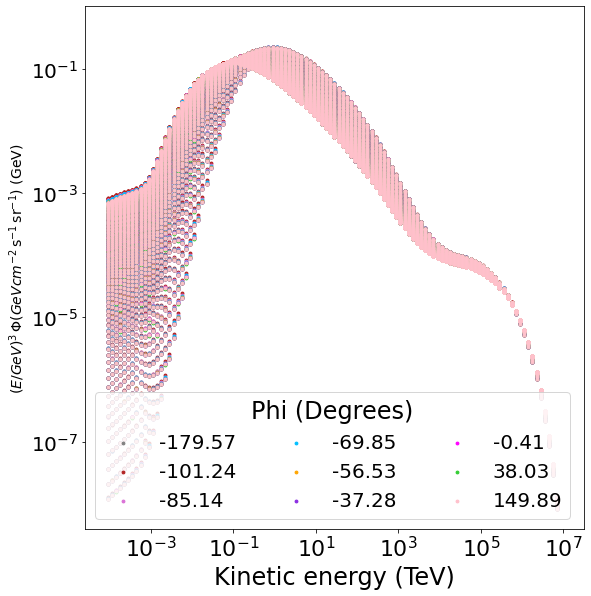

In [11]:
plt.figure(figsize=(8,8))
# Obtain the result
# Multiply fluxes be E**mag to resolve the features of the steep spectrum

l=mussimData.phis.unique()
l.sort()

clr=0
Ths=45

# The lines below are for plotting with matplotlib
#for theta in k:
for phi in l[0:len(l):85]:
    x=mussimData[(mussimData.phis==phi)&(mussimData.MuFLux>10**-9)].Energies*GeV/10**6
    y=mussimData[(mussimData.phis==phi)&(mussimData.MuFLux>10**-9)].MuFLux


    
    plt.scatter(x, y, label=str(phi),s=8,color=CLRS[clr])

    clr+=1
    

plt.yscale('log')
plt.xscale('log')
plt.xticks(fontsize=22)
plt.yticks(fontsize=20)
plt.tight_layout()
#plt.xlim(1., 2e2)
plt.xlabel('Kinetic energy (TeV)',fontsize=24)
plt.ylim(4e-9, 1.)
plt.ylabel(r'$(E/ {GeV})^3\,\Phi (GeV cm^{-2}\,$s$^{-1}\,$sr$^{-1}$) (GeV)',fontsize=14)
plt.legend(fontsize=20,title='Phi (Degrees)',title_fontsize=24,ncol=3,loc='lower left')
plt.show()






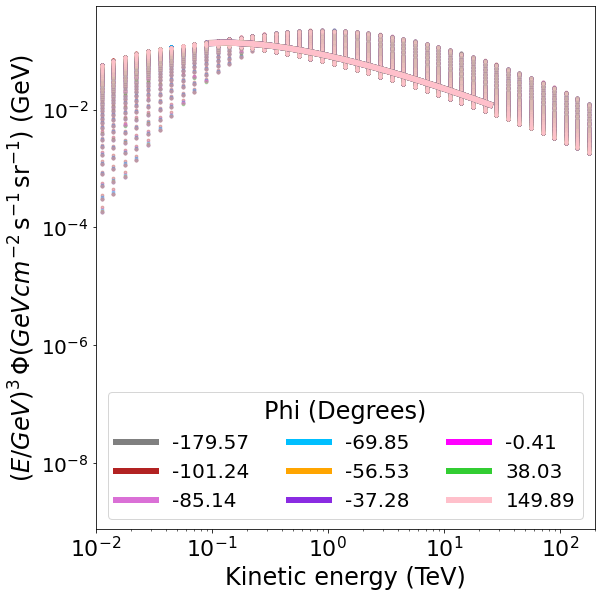

In [12]:
plt.figure(figsize=(8,8))
# Obtain the result
# Multiply fluxes be E**mag to resolve the features of the steep spectrum

#bring in the intorpolation funcs

with open('/Users/rogerslc/Documents/MuFluxPred/MCeQ_Muons_interpolator_PhisPlusNRG.pkl', 'rb') as f:
    FluxMuons = pickle.load(f)

energies=[100,250,500,750,1000,1500,2000,3000,4000,5000,6000,7500,8500,10000,11000,12500,15000,20000,25000]
clr=0
nrgs=np.geomspace(np.min(energies)*10**-3,np.max(energies)*10**-3,20)
    
# The lines below are for plotting with matplotlib
for phi in l[0:len(l):85]:
    #MCeq data
    df=mussimData[(mussimData.phis==phi)&(mussimData.MuFLux>10**-9)]  
    x=df.Energies
    y=df.MuFLux
    
    flxs=[]
    

    
    for NG in nrgs:
        flxs.append(FluxMuons(phi,NG/(GeV/10**6))[0][0])

    plt.scatter(x*GeV/10**6, y, label='_nolegend_',alpha=.3,s=8,color=CLRS[clr])        
    plt.plot(nrgs,flxs,linewidth=6,color=CLRS[clr], label=str(phi))
    clr+=1
    
plt.yscale('log')
plt.xscale('log')
plt.xticks(fontsize=22)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.xlim(.01, 2e2)
plt.xlabel('Kinetic energy (TeV)',fontsize=24)
#plt.ylim(4e-9, 1.)
#plt.ylim(4e-3, 1.)

plt.ylabel(r'$(E/ {GeV})^3\,\Phi (GeV cm^{-2}\,$s$^{-1}\,$sr$^{-1}$) (GeV)',fontsize=24)
plt.legend(fontsize=20,title='Phi (Degrees)',title_fontsize=24,ncol=3,loc='lower center')
#plt.savefig("/Users/rogerslc/Documents/MuFluxPred/FluxesForSomeDeg.png",dpi=250,bbox_inches='tight')
plt.show()

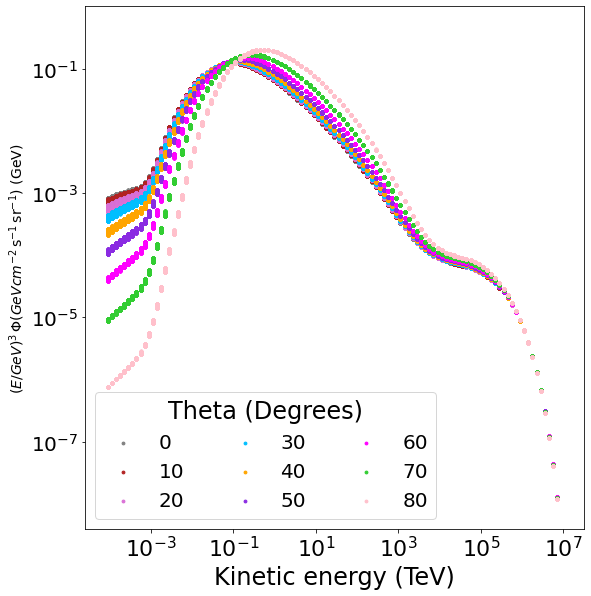

In [13]:
plt.figure(figsize=(8,8))
# Obtain the result
# Multiply fluxes be E**mag to resolve the features of the steep spectrum

k=mussimData.theta.unique()
k.sort()

clr=0

# The lines below are for plotting with matplotlib
#for theta in k:
for theta in range(0,90,10):
    x=mussimData[(mussimData.theta==theta)&(mussimData.MuFLux>10**-9)].Energies*GeV/10**6
    y=mussimData[(mussimData.theta==theta)&(mussimData.MuFLux>10**-9)].MuFLux

    
    plt.scatter(x, y, label=str(theta),s=8,color=CLRS[clr])

    clr+=1
    


plt.yscale('log')
plt.xscale('log')
plt.xticks(fontsize=22)
plt.yticks(fontsize=20)
plt.tight_layout()
#plt.xlim(1., 2e2)
plt.xlabel('Kinetic energy (TeV)',fontsize=24)
plt.ylim(4e-9, 1.)
plt.ylabel(r'$(E/ {GeV})^3\,\Phi (GeV cm^{-2}\,$s$^{-1}\,$sr$^{-1}$) (GeV)',fontsize=14)
plt.legend(fontsize=20,title='Theta (Degrees)',title_fontsize=24,ncol=3,loc='lower left')
plt.show()



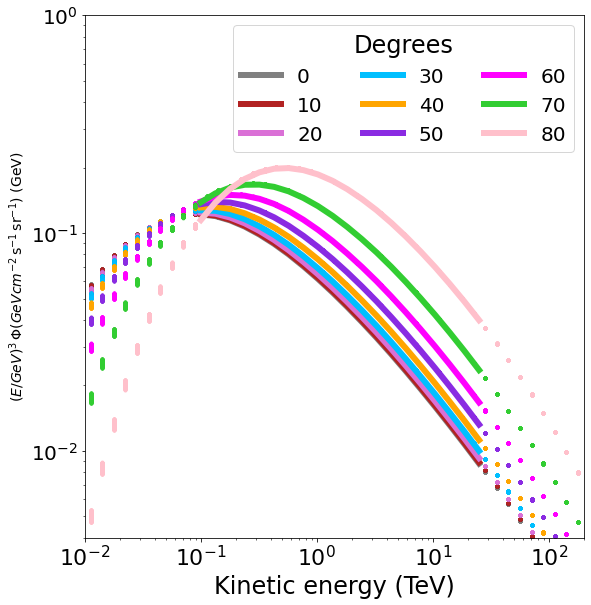

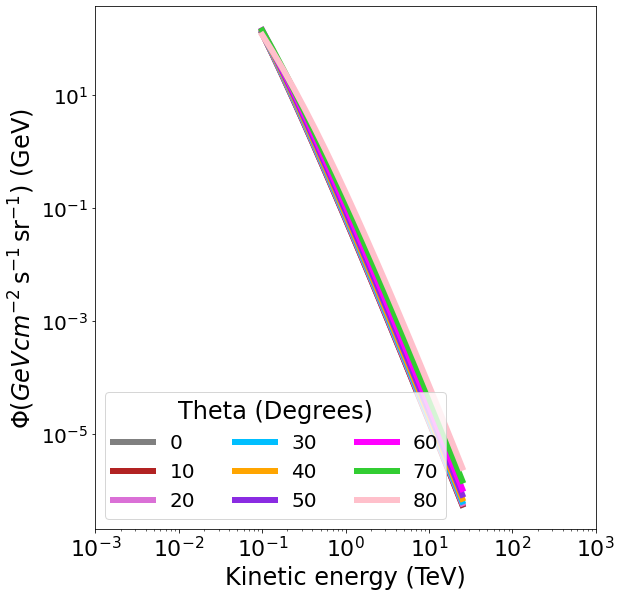

In [14]:
plt.figure(figsize=(8,8))
# Obtain the result
# Multiply fluxes be E**mag to resolve the features of the steep spectrum

k=mussimData.theta.unique()
k.sort()

energies=[100,250,500,750,1000,1500,2000,3000,4000,5000,6000,7500,8500,10000,11000,12500,15000,20000,25000]
clr=0
nrgs=np.geomspace(np.min(energies)*10**-3,np.max(energies)*10**-3,20)
    
# The lines below are for plotting with matplotlib
#for theta in k:
for theta in range(0,90,10):
    #MCeq data
    df=mussimData[(mussimData.theta==theta)&(mussimData.MuFLux>10**-9)]  
    x=df.Energies
    y=df.MuFLux
    

    
    #bring in the intorpolation funcs
    flxs=[]
    with open('/Users/rogerslc/Documents/MuFluxPred/MCeQ_Muons_interpolator'+str(theta)+'.pkl', 'rb') as f:
        FluxMuons = pickle.load(f)
    
    for NG in nrgs:
        flxs.append(FluxMuons(NG/(GeV/10**6),650)[0][0])

    plt.scatter(x*GeV/10**6, y, label='_nolegend_',alpha=.3,s=8,color=CLRS[clr])        
    plt.plot(nrgs,flxs,linewidth=6,color=CLRS[clr], label=str(theta))
    clr+=1
    
plt.yscale('log')
plt.xscale('log')
plt.xticks(fontsize=22)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.xlim(.01, 2e2)
plt.xlabel('Kinetic energy (TeV)',fontsize=24)
#plt.ylim(4e-9, 1.)
plt.ylim(4e-3, 1.)

plt.ylabel(r'$(E/ {GeV})^3\,\Phi (GeV cm^{-2}\,$s$^{-1}\,$sr$^{-1}$) (GeV)',fontsize=14)
plt.legend(fontsize=20,title='Degrees',title_fontsize=24,ncol=3,loc='upper right')
#plt.savefig("/Users/rogerslc/Documents/MuFluxPred/FluxesForSomeDeg.png",dpi=250,bbox_inches='tight')
plt.show()

nrgs=np.geomspace(np.min(energies)*10**-3,np.max(energies)*10**-3,20)
plt.figure(figsize=(8,8))   
clr=0
for theta in range(0,90,10):
    flxs=[]
    with open('/Users/rogerslc/Documents/MuFluxPred/MCeQ_Muons_interpolator'+str(theta)+'.pkl', 'rb') as f:
        FluxMuons = pickle.load(f)
    
    for NG in nrgs:
        flxs.append(FluxMuons(NG/(GeV/10**6),650)[0][0]/NG**3)
        
    plt.plot(nrgs,flxs,linewidth=6,color=CLRS[clr], label=str(theta))
    clr+=1
    
plt.yscale('log')
plt.xscale('log')
plt.xticks(fontsize=22)
plt.yticks(fontsize=20)
plt.tight_layout()
#plt.xlim(1., 2e2)
plt.xlabel('Kinetic energy (TeV)',fontsize=24)
#plt.ylim(4e-4, 1.)
plt.xlim(1e-3, 1e3)
plt.ylabel(r'$\Phi (GeV cm^{-2}\,$s$^{-1}\,$sr$^{-1}$) (GeV)',fontsize=24)
plt.legend(fontsize=20,title='Theta (Degrees)',title_fontsize=24,ncol=3,loc='lower left')
#plt.savefig("/Users/rogerslc/Documents/MuFluxPred/FluxesForSomeDeg.png",dpi=250,bbox_inches='tight')
plt.show()

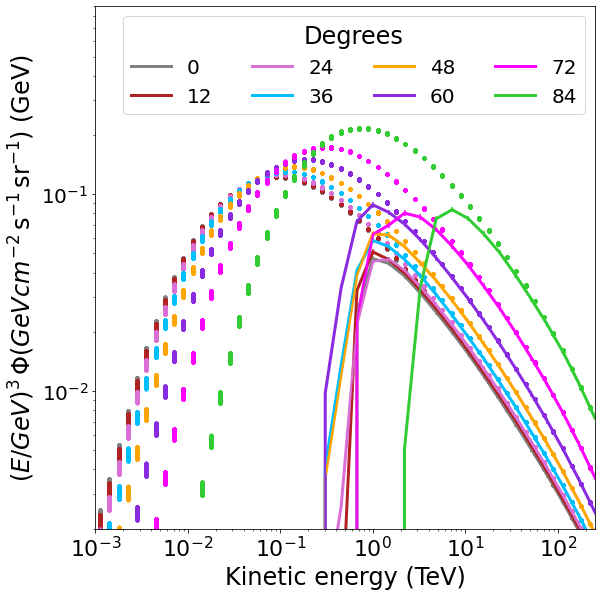

In [15]:
#need to multiply flux by percent
plt.figure(figsize=(8,8))
# Obtain the result
# Multiply fluxes be E**mag to resolve the features of the steep spectrum

k=mussimData.theta.unique()
k.sort()

#bring in the intorpolation funcs
with open('/Users/rogerslc/Documents/MuFluxPred/MCeQ_Muons_interpolator_ALL.pkl', 'rb') as f:
    FluxMuons = pickle.load(f) #use as FluxMuons(theta,energy)

with open('/Users/rogerslc/PROPOSAL/PROPOSAL/Proposal_Muons_interpolator_ALL.pkl', 'rb') as f:
    PercentMuons = pickle.load(f) #use as PercentMuons(energy,theta)

clr=0
Nmin=.001
nrgs=np.geomspace(Nmin,2.5e5,50)


    
# The lines below are for plotting with matplotlib
#for theta in k:
for theta in range(0,90,12):

    flxs=[]     
    flxs2=[]
    err=[]
    with open('/Users/rogerslc/Documents/MuFluxPred/MCeQ_Muons_interpolator'+str(theta)+'.pkl', 'rb') as f:
        FluxMuons = pickle.load(f)
    for NG in nrgs:            
        flxs.append(FluxMuons(NG,650)[0][0]*PercentMuons(NG,theta)[0])   
        flxs2.append(FluxMuons(NG,650)[0][0])
        err.append((FluxMuons(NG,650)[0][0]*PercentMuons(NG,theta)[0])/NumToRun**.5)
        #print(NG,FluxMuons(NG,650)[0][0])

    #plt.plot(nrgs*GeV/10**6,flxs2,linewidth=6,color=CLRS[clr], label='_nolegend_')    
    plt.errorbar(nrgs*(GeV/10**6),flxs,yerr=err,xerr=None,color=CLRS[clr], label='_nolegend_')
      
    plt.plot(nrgs*GeV/10**6,flxs,linewidth=3,color=CLRS[clr], label=str(theta))

    
    #MCeq data
    df=mussimData[(mussimData.theta==theta)&(mussimData.MuFLux>10**-9)&(mussimData.Energies>4)]  
    x=df.Energies
    y=df.MuFLux
    
    x=mussimData[(mussimData.theta==theta)&(mussimData.MuFLux>10**-9)].Energies*GeV/10**6
    y=mussimData[(mussimData.theta==theta)&(mussimData.MuFLux>10**-9)].MuFLux
    plt.scatter(x, y, label='_nolegend_',s=8,color=CLRS[clr])
    
    #plt.scatter(x*GeV/10**6, y, label='_nolegend_',alpha=.3,s=8,color=CLRS[clr])      
    clr+=1
    
#for N in energies:
    #plt.vlines(N*(GeV/10**6),2e-3, 9e-1)
    
plt.yscale('log')
plt.xscale('log')
plt.xticks(fontsize=22)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.xlim(Nmin, 2.5e2)
#plt.xlim(.4, 1.1)
plt.xlabel('Kinetic energy (TeV)',fontsize=24)
#plt.ylim(4e-8, 4e-3)
#plt.ylim(4e-3, 1.)
plt.ylim(2e-3, 9e-1)

plt.ylabel(r'$(E/ {GeV})^3\,\Phi (GeV cm^{-2}\,$s$^{-1}\,$sr$^{-1}$) (GeV)',fontsize=24)
plt.legend(fontsize=20,title='Degrees',title_fontsize=24,ncol=4,loc='upper right')
#plt.savefig("/Users/rogerslc/Documents/MuFluxPred/FluxesForSomeDeg.png",dpi=250,bbox_inches='tight')
plt.show()



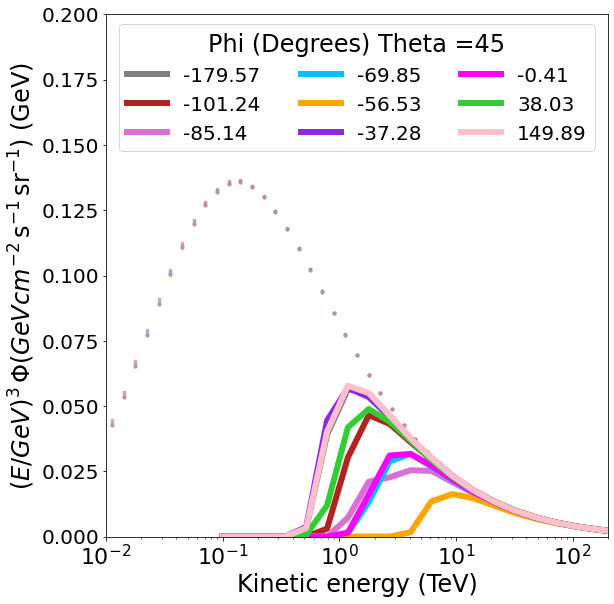

In [45]:
plt.figure(figsize=(8,8))
# Obtain the result
# Multiply fluxes be E**mag to resolve the features of the steep spectrum

#bring in the intorpolation funcs

with open('/Users/rogerslc/Documents/MuFluxPred/MCeQ_Muons_interpolator_PhisPlusNRG.pkl', 'rb') as f:
    FluxMuons = pickle.load(f)
    
    
#bring in the intorpolation funcs
with open('/Users/rogerslc/PROPOSAL/PROPOSAL/Proposal_Muons_interpolator_ALL_Phi.pkl', 'rb') as f:
    PercentMuons = pickle.load(f) #use as PercentMuons(energy,phi)



    

energies=[100,250,500,750,1000,1500,2000,3000,4000,5000,6000,7500,8500,10000,11000,12500,15000,20000,25000]
clr=0
nrgs=np.geomspace(np.min(energies)*10**-3,250000*10**-3,20)
    
# The lines below are for plotting with matplotlib
for phi in l[0:len(l):85]:
    #MCeq data
    df=mussimData[(mussimData.phis==phi)&(mussimData.MuFLux>10**-9)&(mussimData.theta==45)]  
    x=df.Energies
    y=df.MuFLux
    
    flxs=[]
    percs=[]
    

    
    for NG in nrgs:
        flxs.append(FluxMuons(phi,NG/(GeV/10**6))[0][0]*PercentMuons(NG*10**3,phi)[0])
        #print(FluxMuons(phi,NG/(GeV/10**6))[0][0],PercentMuons(NG*10**3,phi)[0])
        
    
    #print(flxs)
    plt.scatter(x*GeV/10**6, y, label='_nolegend_',alpha=.3,s=8,color=CLRS[clr])        
    plt.plot(nrgs,flxs,linewidth=6,color=CLRS[clr], label=str(phi))
    clr+=1
    
#plt.yscale('log')
plt.xscale('log')
plt.xticks(fontsize=22)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.xlim(.01, 2e2)
plt.xlabel('Kinetic energy (TeV)',fontsize=24)
#plt.ylim(4e-9, 1.)
plt.ylim(0, .2)

plt.ylabel(r'$(E/ {GeV})^3\,\Phi (GeV cm^{-2}\,$s$^{-1}\,$sr$^{-1}$) (GeV)',fontsize=24)
plt.legend(fontsize=20,title='Phi (Degrees) Theta =45',title_fontsize=24,ncol=3,loc='upper center')
#plt.savefig("/Users/rogerslc/Documents/MuFluxPred/FluxesForSomeDeg.png",dpi=250,bbox_inches='tight')
plt.show()

In [17]:
len(energies)

19

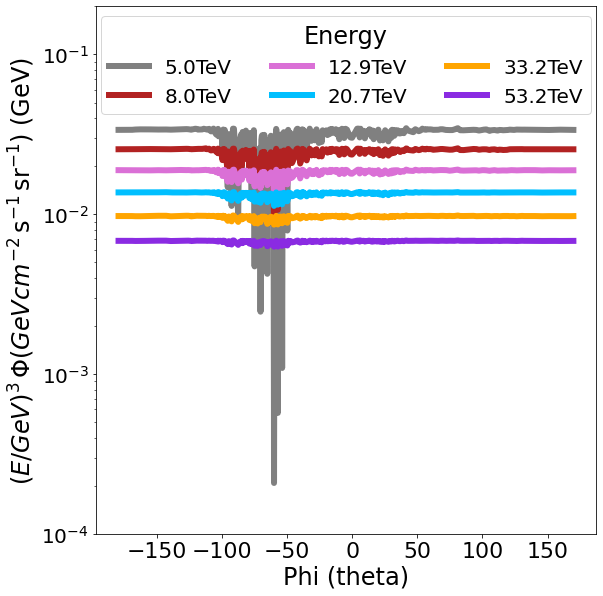

In [77]:
plt.figure(figsize=(8,8))
# Obtain the result
# Multiply fluxes be E**mag to resolve the features of the steep spectrum

#bring in the intorpolation funcs

with open('/Users/rogerslc/Documents/MuFluxPred/MCeQ_Muons_interpolator_PhisPlusNRG.pkl', 'rb') as f:
    FluxMuons = pickle.load(f)
    
    
#bring in the intorpolation funcs
with open('/Users/rogerslc/PROPOSAL/PROPOSAL/Proposal_Muons_interpolator_ALL_Phi.pkl', 'rb') as f:
    PercentMuons = pickle.load(f) #use as PercentMuons(energy,phi)



    

energies=[100,250,500,750,1000,1500,2000,3000,4000,5000,6000,7500,8500,10000,11000,12500,15000,20000,25000]
clr=0
nrgs=energies
nrgs=np.geomspace(5000*10**-3,100000*10**-3,20)
    
# The lines below are for plotting with matplotlib
for NG in nrgs[0:17:3]:
    
    flxs=[]
    percs=[]
    

    
    
    for phi in l:
        flxs.append(FluxMuons(phi,NG/(GeV/10**6))[0][0]*PercentMuons(NG*10**3,phi)[0])
        #print(FluxMuons(phi,NG/(GeV/10**6))[0][0],PercentMuons(NG*10**3,phi)[0])
        
       
    plt.plot(l,flxs,linewidth=6, color=CLRS[clr], label=str(np.round(NG,1))+'TeV')
    #print(flxs)
    clr+=1
    
plt.yscale('log')
#plt.xscale('log')
plt.xticks(fontsize=22)
plt.yticks(fontsize=20)
plt.tight_layout()
#plt.xlim(-120, -50)
plt.xlabel('Phi (theta)',fontsize=24)
#plt.ylim(4e-9, 1.)
plt.ylim(1e-4, 2e-1)

plt.ylabel(r'$(E/ {GeV})^3\,\Phi (GeV cm^{-2}\,$s$^{-1}\,$sr$^{-1}$) (GeV)',fontsize=24)
plt.legend(fontsize=20,title='Energy',title_fontsize=24,ncol=3,loc='upper center')
#plt.savefig("/Users/rogerslc/Documents/MuFluxPred/FluxesForSomeDeg.png",dpi=250,bbox_inches='tight')
plt.show()

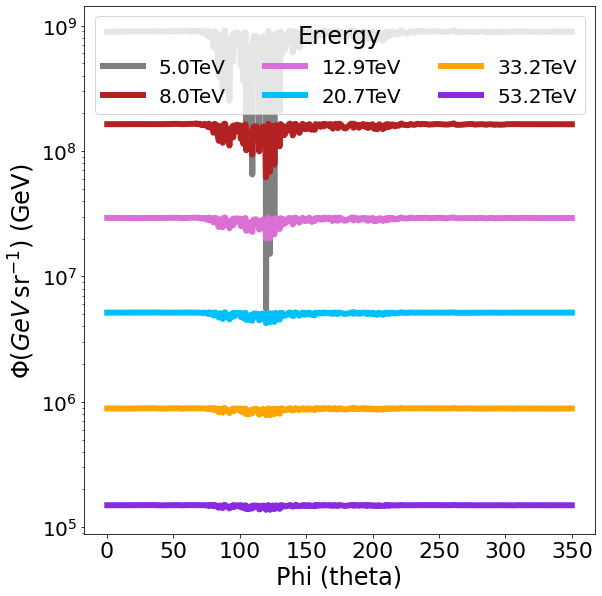

In [88]:
plt.figure(figsize=(8,8))
# Obtain the result
# Multiply fluxes be E**mag to resolve the features of the steep spectrum

#bring in the intorpolation funcs

with open('/Users/rogerslc/Documents/MuFluxPred/MCeQ_Muons_interpolator_PhisPlusNRG.pkl', 'rb') as f:
    FluxMuons = pickle.load(f)
    
    
#bring in the intorpolation funcs
with open('/Users/rogerslc/PROPOSAL/PROPOSAL/Proposal_Muons_interpolator_ALL_Phi.pkl', 'rb') as f:
    PercentMuons = pickle.load(f) #use as PercentMuons(energy,phi)



    

energies=[100,250,500,750,1000,1500,2000,3000,4000,5000,6000,7500,8500,10000,11000,12500,15000,20000,25000]
clr=0
nrgs=energies
nrgs=np.geomspace(5000*10**-3,100000*10**-3,20)
    
# The lines below are for plotting with matplotlib
for NG in nrgs[0:17:3]:
    
    flxs=[]
    percs=[]
    

    
    
    for phi in l:
        flxs.append(FluxMuons(phi,NG/(GeV/10**6))[0][0]*PercentMuons(NG*10**3,phi)[0]/NG**3*(365.25*24*60*60)*AreaOfNextNEW)
        #print(FluxMuons(phi,NG/(GeV/10**6))[0][0],PercentMuons(NG*10**3,phi)[0])
        
       
    plt.plot(l+180,flxs,linewidth=6, color=CLRS[clr], label=str(np.round(NG,1))+'TeV')
    #print(flxs)
    clr+=1
    
plt.yscale('log')
#plt.xscale('log')
plt.xticks(fontsize=22)
plt.yticks(fontsize=20)
plt.tight_layout()
#plt.xlim(-120, -50)
plt.xlabel('Phi (theta)',fontsize=24)
#plt.ylim(4e-9, 1.)
#plt.ylim(2e-8, 4e-3)

plt.ylabel(r'$\Phi (GeV \,$sr$^{-1}$) (GeV)',fontsize=24)
plt.legend(fontsize=20,title='Energy',title_fontsize=24,ncol=3,loc='upper center')
#plt.savefig("/Users/rogerslc/Documents/MuFluxPred/FluxesForSomeDeg.png",dpi=250,bbox_inches='tight')
plt.show()

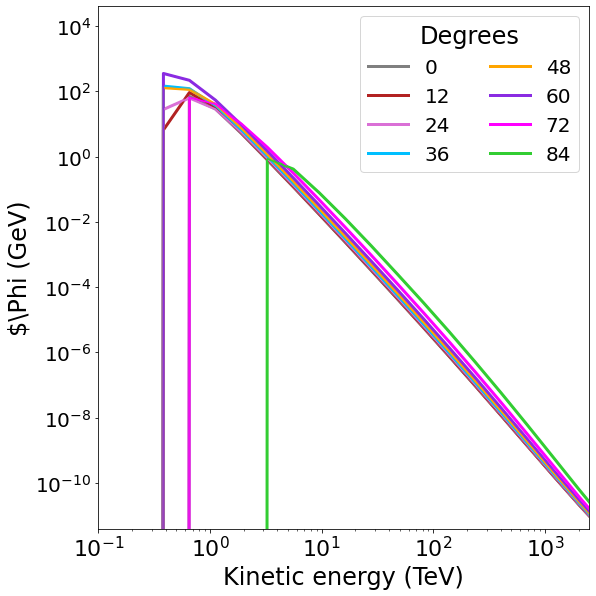

In [19]:
#need to multiply flux by percent
plt.figure(figsize=(8,8))
# Obtain the result
# Multiply fluxes be E**mag to resolve the features of the steep spectrum

k=mussimData.theta.unique()
k.sort()

#bring in the intorpolation funcs
with open('/Users/rogerslc/Documents/MuFluxPred/MCeQ_Muons_interpolator_ALL.pkl', 'rb') as f:
    FluxMuons = pickle.load(f) #use as FluxMuons(theta,energy)

with open('/Users/rogerslc/PROPOSAL/PROPOSAL/Proposal_Muons_interpolator_ALL.pkl', 'rb') as f:
    PercentMuons = pickle.load(f) #use as PercentMuons(energy,theta)

clr=0
Nmin=.001
nrgs=np.geomspace(Nmin,2.5e8,50)


    
# The lines below are for plotting with matplotlib
#for theta in k:
for theta in range(0,90,12):
    flxs=[]     
    flxs2=[]
    err=[]
    with open('/Users/rogerslc/Documents/MuFluxPred/MCeQ_Muons_interpolator'+str(theta)+'.pkl', 'rb') as f:
        FluxMuons = pickle.load(f)
    for NG in nrgs:            
        

        flxs.append(FluxMuons(NG,650)[0][0]*PercentMuons(NG,theta)[0]*40*55/NG**3*365.25*24*60*60*4*np.pi)   
        err.append((FluxMuons(NG,650)[0][0]*PercentMuons(NG,theta)[0]*40*55/NG**3*365.25*24*60*60*4*np.pi)/NumToRun**.5)

    plt.errorbar(nrgs*(GeV/10**6),flxs,yerr=err,xerr=None,color=CLRS[clr], label='_nolegend_')
      
    plt.plot(nrgs*GeV/10**6,flxs,linewidth=3,color=CLRS[clr], label=str(theta))


    
    #plt.scatter(x*GeV/10**6, y, label='_nolegend_',alpha=.3,s=8,color=CLRS[clr])      
    clr+=1
    
plt.yscale('log')
plt.xscale('log')
plt.xticks(fontsize=22)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.xlim(1e-1, 2.5e3)
plt.xlabel('Kinetic energy (TeV)',fontsize=24)
plt.ylim(4e-12, 4e4)
#plt.ylim(4e-3, 1.)
#plt.ylim(2e-3, 9e-1)

plt.ylabel(r'$\Phi (GeV)',fontsize=24)
plt.legend(fontsize=20,title='Degrees',title_fontsize=24,ncol=2,loc='upper right')
#plt.savefig("/Users/rogerslc/Documents/MuFluxPred/FluxesYear.png",dpi=250,bbox_inches='tight')
plt.show()




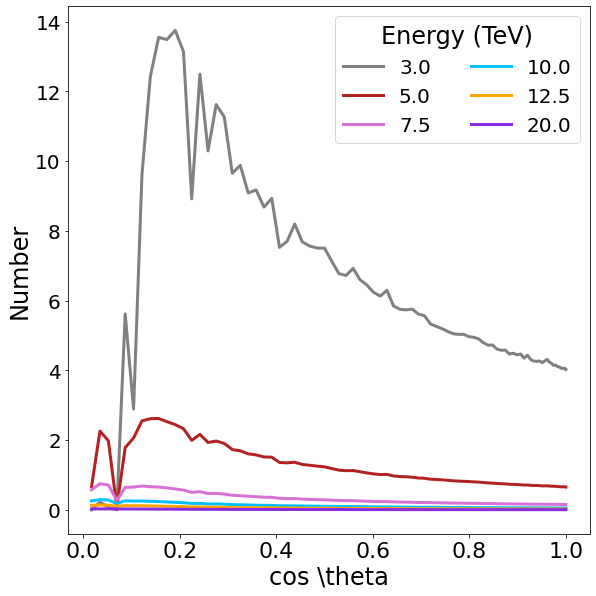

In [89]:
#need to multiply flux by percent
plt.figure(figsize=(8,8))
# Obtain the result
# Multiply fluxes be E**mag to resolve the features of the steep spectrum

k=mussimData.theta.unique()
k.sort()
#k=range(0,90,5)
'''
#bring in the intorpolation funcs
with open('/Users/rogerslc/Documents/MuFluxPred/MCeQ_Muons_interpolator_ALL.pkl', 'rb') as f:
    FluxMuons = pickle.load(f) #use as FluxMuons(theta,energy)'''

with open('/Users/rogerslc/PROPOSAL/PROPOSAL/Proposal_Muons_interpolator_ALL.pkl', 'rb') as f:
    PercentMuons = pickle.load(f) #use as PercentMuons(energy,theta)

clr=0
Nmin=.1/(GeV/10**6)
Nmax=4/(GeV/10**6)
#nrgs=np.linspace(Nmin,Nmax,10)
nrgs=energies
Nmin=.001
#nrgs=np.geomspace(Nmin,2.5e5,50)

    
# The lines below are for plotting with matplotlib
#for theta in k:

for NG in  nrgs[7:len(nrgs):2]:  
    flxs=[]     
    flxs2=[]
    err=[]
    #with open('/Users/rogerslc/PROPOSAL/PROPOSAL/Proposal_Muons_interpolator'+str(NG*10**3)+'TeV.pkl', 'rb') as f:
        #PercentMuons = pickle.load(f)



    for thetas in k:  
        
        with open('/Users/rogerslc/Documents/MuFluxPred/MCeQ_Muons_interpolator'+str(thetas)+'.pkl', 'rb') as f:
            FluxMuons = pickle.load(f)
        flxs.append(FluxMuons(NG,650)[0][0]*PercentMuons(NG,thetas)[0]/NG**3*(365.25*24*60*60)*AreaOfNextNEW)   
        err.append((FluxMuons(NG,650)[0][0]*PercentMuons(NG,thetas)[0])/NumToRun**.5)
        #print(np.round(np.cos(np.deg2rad(thetas)),2),np.round(NG,2),FluxMuons(NG,650)[0][0],PercentMuons(NG,thetas)[0])

    #plt.errorbar(nrgs*(GeV/10**6),flxs,yerr=err,xerr=None,color=CLRS[clr], label='_nolegend_')
      
    plt.plot(np.cos(np.deg2rad(k)),flxs,linewidth=3, label=str(np.round(NG*(GeV/10**6),2)),color=CLRS[clr])
    #plt.plot(k,flxs,linewidth=3, label=str(np.round(NG*(GeV/10**6),2)))

    
    #plt.scatter(x*GeV/10**6, y, label='_nolegend_',alpha=.3,s=8,color=CLRS[clr])      
    clr+=1
    
#plt.yscale('log')
#plt.xscale('log')
plt.xticks(fontsize=22)
plt.yticks(fontsize=20)
plt.tight_layout()
#plt.xlim(1e-1, 2.5e3)
plt.xlabel(r'cos \theta',fontsize=24)
#plt.ylim(-.01, .3)
#plt.ylim(4e-3, 1.)
#plt.ylim(2e-3, 9e-1)

plt.ylabel('Number',fontsize=24)
plt.legend(fontsize=20,title='Energy (TeV)',title_fontsize=24,ncol=2,loc='upper right')
#plt.savefig("/Users/rogerslc/Documents/MuFluxPred/FluxesYear.png",dpi=250,bbox_inches='tight')
plt.show()





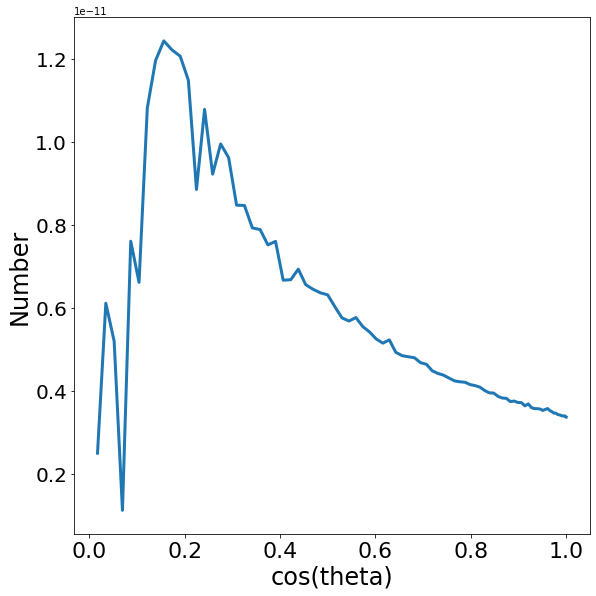

In [21]:


clr=0
Nmin=3/(GeV/10**6)
Nmax=50/(GeV/10**6)
nrgs=np.linspace(Nmin,Nmax,90)


    
# The lines below are for plotting with matplotlib
#for theta in k:
flxs2=[]
for NG in nrgs:
    flxs=[]     

    err=[]

    for thetas in k:  
        with open('/Users/rogerslc/Documents/MuFluxPred/MCeQ_Muons_interpolator'+str(thetas)+'.pkl', 'rb') as f:
            FluxMuons = pickle.load(f)
        nums=FluxMuons(NG,650)[0][0]*PercentMuons(NG,thetas)[0]/NG**3
        flxs.append(nums)   

        
        if NG==Nmin:
            flxs2.append(nums)
        else:
            flxs2[thetas]+=(nums)

plt.figure(figsize=(8,8))
plt.plot(np.cos(np.deg2rad(k)),flxs2,linewidth=3, label=str(np.round(NG*(GeV/10**6),1)))           
plt.xticks(fontsize=22)
plt.yticks(fontsize=20)
plt.tight_layout()
#plt.xlim(1e-1, 2.5e3)
plt.xlabel('cos(theta)',fontsize=24)
#plt.ylim(-.01, .3)


plt.ylabel('Number',fontsize=24)
#plt.legend(fontsize=20,title='NRG',title_fontsize=24,ncol=3,loc='upper right')
#plt.savefig("/Users/rogerslc/Documents/MuFluxPred/FluxesYear.png",dpi=250,bbox_inches='tight')
plt.show()

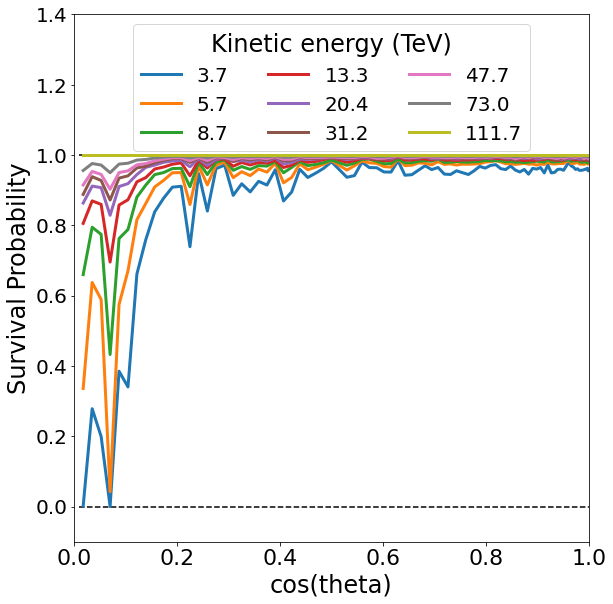

In [22]:

plt.figure(figsize=(8,8))

k=mussimData.theta.unique()
k.sort()
energies=musDatamtn.Energy.unique()

#bring in the intorpolation funcs
with open('/Users/rogerslc/PROPOSAL/PROPOSAL/Proposal_Muons_interpolator_ALL.pkl', 'rb') as f:
    PercentMuons = pickle.load(f) #use as PercentMuons(energy,theta)

clr=0
nrgs=np.geomspace(np.min(energies*10**-3),4e5,40)
#nrgs=energies*10**-3

    
# The lines below are for plotting with matplotlib
#for theta in k:
for NG in  nrgs[17:len(nrgs)-5:2]:   

    flxs=[]     
    err=[]
    for theta in k:
        flxs.append(PercentMuons(NG,theta)[0])   
        err.append((PercentMuons(NG,theta)[0]*NumToRun)**.5/1000)
    #plt.plot(nrgs*(GeV/10**6),flxs,linewidth=3,color=CLRS[clr], label=str(theta))
    #plt.errorbar(nrgs*(GeV/10**6),flxs,yerr=err,xerr=None,color=CLRS[clr])
    plt.plot(np.cos(np.deg2rad(k)),flxs,linewidth=3, label=str(np.round(NG*10**-3,1)))
    #plt.plot(k,flxs,linewidth=3, label=str(np.round(NG,1)))
    clr+=1
    
plt.hlines(0,10**-2,10**2,color='k',linestyle='--')
plt.hlines(1,10**-2,10**2,color='k',linestyle='--')

#plt.yscale('log')
#plt.xscale('log')
plt.xticks(fontsize=22)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.xlim(0, 1)
plt.xlabel('cos(theta)',fontsize=24)
#plt.ylim(-4e-3, 4e-3)
plt.ylim(-.1, 1.4)

plt.ylabel(r'Survival Probability',fontsize=24)
plt.legend(fontsize=20,title='Kinetic energy (TeV)',title_fontsize=24,ncol=3,loc='upper center')
#plt.savefig("/Users/rogerslc/Documents/MuFluxPred/FluxesForSomeDeg.png",dpi=250,bbox_inches='tight')
plt.show()




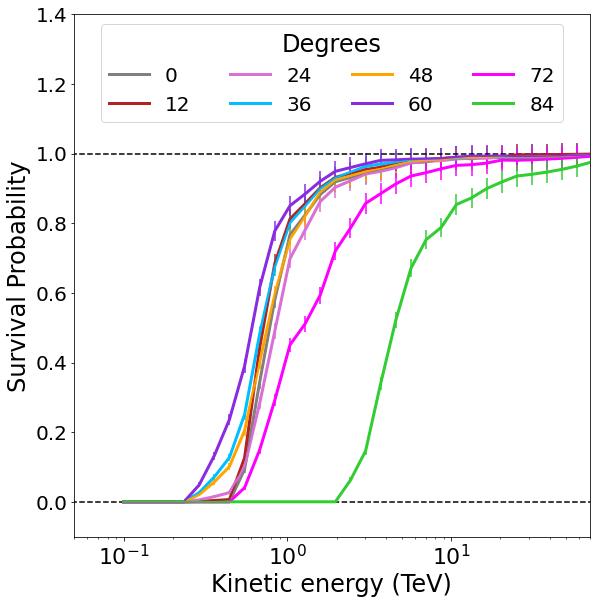

In [23]:

plt.figure(figsize=(8,8))

k=mussimData.theta.unique()
k.sort()
energies=musDatamtn.Energy.unique()

#bring in the intorpolation funcs
with open('/Users/rogerslc/PROPOSAL/PROPOSAL/Proposal_Muons_interpolator_ALL.pkl', 'rb') as f:
    PercentMuons = pickle.load(f) #use as PercentMuons(energy,theta)

clr=0
nrgs=np.geomspace(np.min(energies*10**-3),4e5,40)
#nrgs=energies*10**-3

    
# The lines below are for plotting with matplotlib
#for theta in k:
for theta in range(0,90,12):
    flxs=[]     
    err=[]
    for NG in  nrgs:     
        flxs.append(PercentMuons(NG,theta)[0])   
        err.append((PercentMuons(NG,theta)[0]*NumToRun)**.5/1000)
    #plt.plot(nrgs*(GeV/10**6),flxs,linewidth=3,color=CLRS[clr], label=str(theta))
    #plt.errorbar(nrgs*(GeV/10**6),flxs,yerr=err,xerr=None,color=CLRS[clr])
    plt.plot(nrgs*10**-3,flxs,linewidth=3,color=CLRS[clr], label=str(theta))
    plt.errorbar(nrgs*10**-3,flxs,yerr=err,xerr=None,color=CLRS[clr])
    clr+=1
    
plt.hlines(0,10**-2,10**2,color='k',linestyle='--')
plt.hlines(1,10**-2,10**2,color='k',linestyle='--')

#plt.yscale('log')
plt.xscale('log')
plt.xticks(fontsize=22)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.xlim(.05, 7e1)
plt.xlabel('Kinetic energy (TeV)',fontsize=24)
#plt.ylim(-4e-3, 4e-3)
plt.ylim(-.1, 1.4)

plt.ylabel(r'Survival Probability',fontsize=24)
plt.legend(fontsize=20,title='Degrees',title_fontsize=24,ncol=4,loc='upper center')
#plt.savefig("/Users/rogerslc/Documents/MuFluxPred/FluxesForSomeDeg.png",dpi=250,bbox_inches='tight')
plt.show()



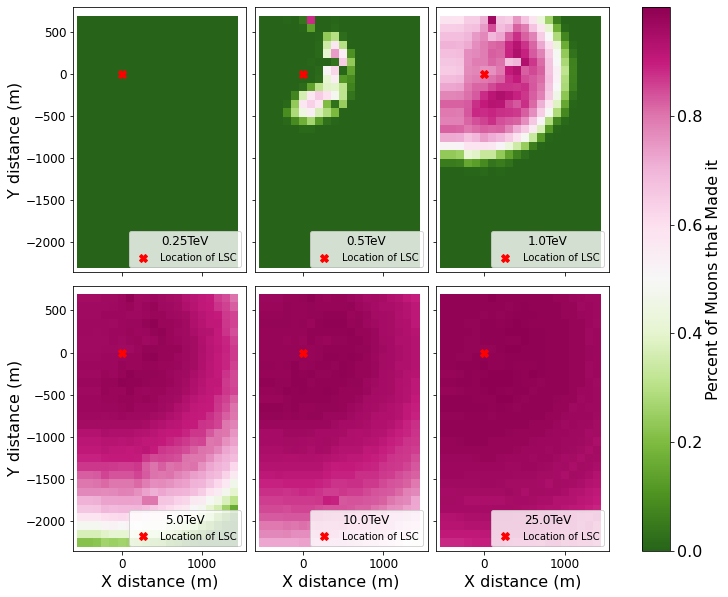

In [24]:
a=0

locs=[1,2,3,4,5,8]



spacing=100
NumToRun=1000
Xmin=-500-spacing
Xmax=1500+spacing/2
Ymin=-2255-spacing
Ymax=745+spacing/2

fig, axes = plt.subplots(nrows=2, ncols=3,figsize=(12,10), sharex=True, sharey=True)
cmap = plt.get_cmap('PiYG')
for ax in axes.flat:
    LOC=locs[a]
    


    NRG=energies[LOC]

    with open('/Users/rogerslc/PROPOSAL/PROPOSAL/Proposal_Muons_interpolator'+str(NRG)+'TeV.pkl', 'rb') as f:
        PercentMuons = pickle.load(f)

    intexs=[]
    inteys=[]
    intepercs=[]
    for X in range(-500,1500,spacing):
        for Y in range(-2255,745,spacing):
            intexs.append(X)
            inteys.append(Y)
            intepercs.append(PercentMuons(X,Y)[0][0])


    intepercs = np.array(intepercs)
    intepercs=intepercs.reshape(len(np.unique(intexs)), len(np.unique(inteys)))
            
    
    im=ax.pcolormesh(np.unique(intexs),np.unique(inteys),np.transpose(intepercs),cmap=cmap.reversed(),shading='auto',vmin=0, vmax=1)
    ax.set_ylim(Ymin,Ymax)
    ax.set_xlim(Xmin,Xmax)
    ax.tick_params(axis='both', which='major', labelsize=12)


    #ax.title("Energy ="+str(energies[LOC]*GeV/10**6)+"TeV")
    ax.plot([0],[0],'X',label='Location of LSC',color='red',markersize=8)
    ax.legend(loc='lower right',title=str(NRG/10**6)+'TeV',title_fontsize=12)
    

    if (LOC>3):
        ax.set_xlabel("X distance (m)",fontsize=16)
    if (LOC==1) or (LOC==4):        
        ax.set_ylabel("Y distance (m)",fontsize=16)
    a+=1
fig.subplots_adjust(wspace=.05, hspace=.05)

cbar=fig.colorbar(im, ax=axes.ravel().tolist(),label='Percent of Muons that Made it')
cbar.set_ticks(np.arange(0, 1, 0.2))
cbar.set_label('Percent of Muons that Made it', fontsize=16)
cbar.ax.tick_params(labelsize=16)
#fig.clim(0,1)


#fig.savefig("/Users/rogerslc/PROPOSAL/PROPOSAL/SimulatedPercents.png",dpi=250,bbox_inches='tight')

#plt.show()





In [25]:
musData=pd.read_hdf('/Users/rogerslc/MuonData/combinedmuonsfrom94135119.h5')
musData['theta']=musData['theta']-np.deg2rad(30)
musData['theta'] = np.where(musData['theta'] >2*np.pi, (musData['theta']-2*np.pi), musData['theta'])
musData['theta'] = np.where(musData['theta'] <0, (musData['theta']+2*np.pi), musData['theta'])
print(len(musData))

9020


In [26]:
stpsize=15

binsa=np.linspace(0,360+360/stpsize+360/(stpsize*2),stpsize)
bin_centersa = binsa[:-1] + np.diff(binsa) / 2
bin_edgesa=binsa[:-1] 

binsz=np.linspace(0,1+1/stpsize+1/(stpsize*3),stpsize)
bin_centersz = binsz[:-1] + np.diff(binsz) / 2
bin_edgesz=binsz[:-1] 

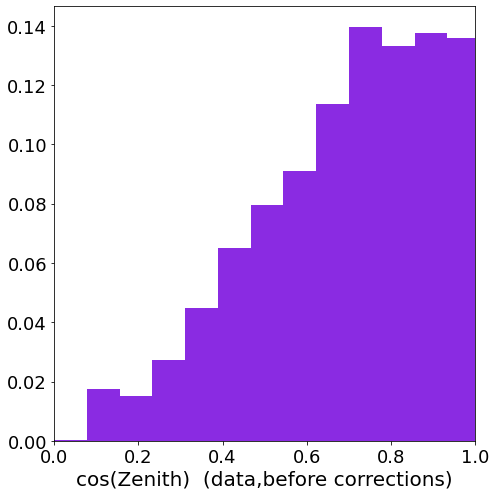

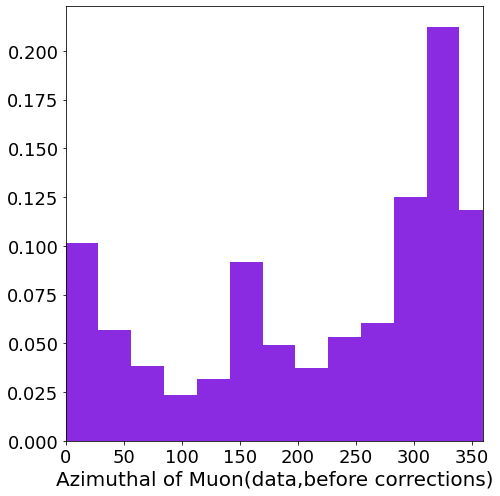

In [27]:
zenhisto, _ = np.histogram(np.cos(musData['phi']), bins = binsz)
azihisto, _ = np.histogram(np.rad2deg(musData['theta']), bins = binsa)

plt.figure(figsize=(7,7))
plt.hist(bin_centersz,weights=zenhisto/zenhisto.sum(),bins=bin_edgesz, color=CLRS[5])
plt.yticks(fontsize=18)  
plt.xticks(fontsize=18) 
#plt.ylim(2e-4,1e0)  
plt.xlim(0,1)
plt.xlabel('cos(Zenith)  (data,before corrections)',fontsize=20)
plt.tight_layout()
#plt.savefig('zenithdata.png',dpi=250,bbox_inches='tight')
plt.show()
           
plt.figure(figsize=(7,7))
plt.hist(bin_centersa,weights=azihisto/azihisto.sum(),bins=bin_edgesa, color=CLRS[5])
plt.yticks(fontsize=18)  
plt.xticks(fontsize=18) 
#plt.ylim(2e-4,1e0)  
plt.xlim(0,360) 
plt.xlabel('Azimuthal of Muon(data,before corrections)',fontsize=20)
plt.tight_layout()
#plt.savefig('azumuthaldata.png',dpi=250,bbox_inches='tight')
plt.show()           

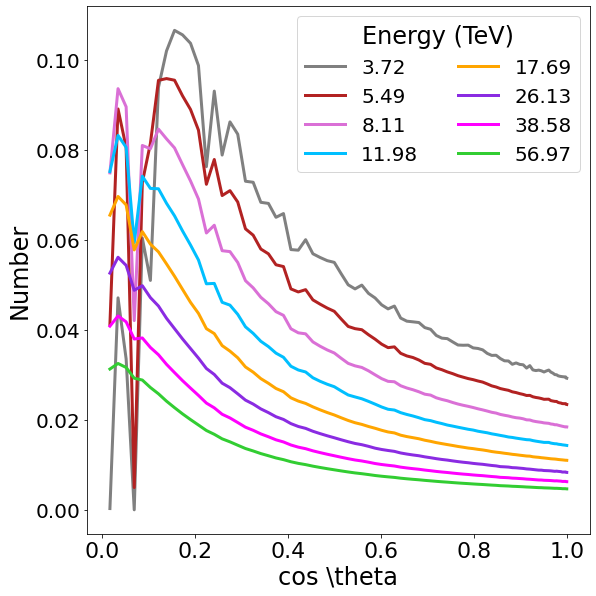

In [95]:
#need to multiply flux by percent
plt.figure(figsize=(8,8))
# Obtain the result
# Multiply fluxes be E**mag to resolve the features of the steep spectrum

k=mussimData.theta.unique()
k.sort()
#k=range(0,90,5)
'''
#bring in the intorpolation funcs
with open('/Users/rogerslc/Documents/MuFluxPred/MCeQ_Muons_interpolator_ALL.pkl', 'rb') as f:
    FluxMuons = pickle.load(f) #use as FluxMuons(theta,energy)'''

with open('/Users/rogerslc/PROPOSAL/PROPOSAL/Proposal_Muons_interpolator_ALL.pkl', 'rb') as f:
    PercentMuons = pickle.load(f) #use as PercentMuons(energy,theta)

clr=0
Nmin=.1/(GeV/10**6)
Nmax=4/(GeV/10**6)
#nrgs=np.linspace(Nmin,Nmax,10)
nrgs=energies
Nmin=.001
#nrgs=np.geomspace(Nmin,2.5e5,50)

    
# The lines below are for plotting with matplotlib
#for theta in k:

nrgs=np.geomspace(np.min(energies)*10**-3,4e5,40)

    
# The lines below are for plotting with matplotlib
#for theta in k:
for NG in  nrgs[27:len(nrgs)-5]:   

 
    flxs=[]     
    flxs2=[]
    err=[]
    #with open('/Users/rogerslc/PROPOSAL/PROPOSAL/Proposal_Muons_interpolator'+str(NG*10**3)+'TeV.pkl', 'rb') as f:
        #PercentMuons = pickle.load(f)



    for thetas in k:  
        
        with open('/Users/rogerslc/Documents/MuFluxPred/MCeQ_Muons_interpolator'+str(thetas)+'.pkl', 'rb') as f:
            FluxMuons = pickle.load(f)
        flxs.append(FluxMuons(NG,650)[0][0]*PercentMuons(NG,thetas)[0])   
        err.append((FluxMuons(NG,650)[0][0]*PercentMuons(NG,thetas)[0])/NumToRun**.5)
        #print(np.round(np.cos(np.deg2rad(thetas)),2),np.round(NG,2),FluxMuons(NG,650)[0][0],PercentMuons(NG,thetas)[0])

    #plt.errorbar(nrgs*(GeV/10**6),flxs,yerr=err,xerr=None,color=CLRS[clr], label='_nolegend_')
      
    plt.plot(np.cos(np.deg2rad(k)),flxs,linewidth=3, label=str(np.round(NG*(GeV/10**6),2)),color=CLRS[clr])
    #plt.plot(k,flxs,linewidth=3, label=str(np.round(NG*(GeV/10**6),2)))

    
    #plt.scatter(x*GeV/10**6, y, label='_nolegend_',alpha=.3,s=8,color=CLRS[clr])      
    clr+=1
    
#plt.yscale('log')
#plt.xscale('log')
plt.xticks(fontsize=22)
plt.yticks(fontsize=20)
plt.tight_layout()
#plt.xlim(1e-1, 2.5e3)
plt.xlabel(r'cos \theta',fontsize=24)
#plt.ylim(-.01, .3)
#plt.ylim(4e-3, 1.)
#plt.ylim(2e-3, 9e-1)

plt.ylabel('Number',fontsize=24)
plt.legend(fontsize=20,title='Energy (TeV)',title_fontsize=24,ncol=2,loc='upper right')
#plt.savefig("/Users/rogerslc/Documents/MuFluxPred/FluxesYear.png",dpi=250,bbox_inches='tight')
plt.show()






In [93]:
 nrgs[26:len(nrgs)-5]

array([ 2519.84209979,  3720.97641304,  5494.65598163,  8113.79622044,
       11981.40326292, 17692.58436475, 26126.11683581, 38579.66517758,
       56969.45223695])